In [3]:
%load_ext autoreload
%autoreload 2

In [1]:
%matplotlib inline

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from dialogue_classification.dataset_utils import load_swda_corpus_data

In [25]:
from dialogue_classification.train_test_split import train_set_idx, valid_set_idx, test_set_idx

In [2]:
talks, talk_names, tag_indices, tag_occurances = load_swda_corpus_data('swda/swda/swda')

Loading SwDA Corpus...

Found 43 different utterance tags.

Loaded SwDA Corpus.


In [9]:
len(talks), len(talk_names)

(1155, 1155)

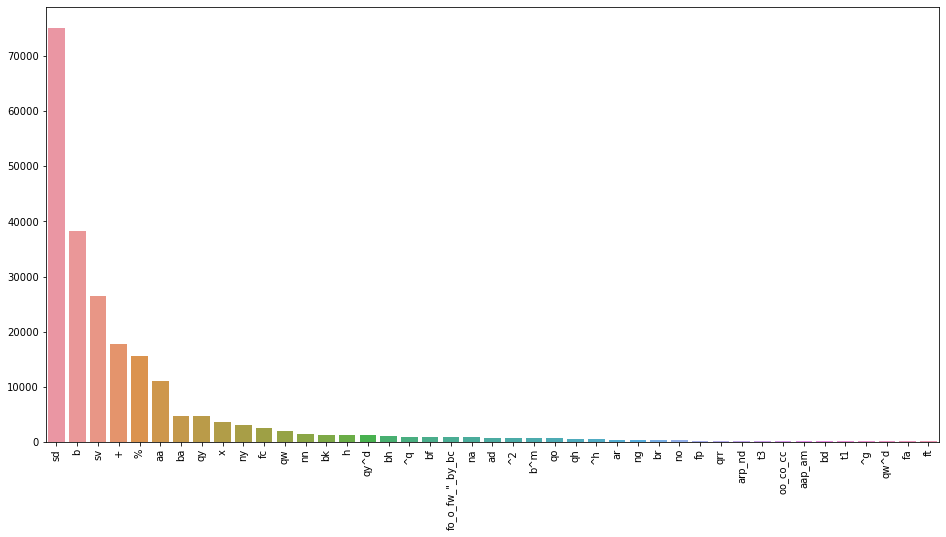

In [19]:
tag_occurances = pd.Series(tag_occurances)
tag_occurances = tag_occurances.sort_values(ascending=False)

plt.figure(figsize=(16, 8))
sns.barplot(x=tag_occurances.index, y=tag_occurances.values)
plt.xticks(rotation=90)
plt.show()

In [21]:
texts, labels = [], []
for text, label in talks:
    assert len(text) == len(label)
    text = [' '.join(utterance) for utterance in text]
    texts.append(text)
    labels.append(label)

In [26]:
len(train_set_idx), len(valid_set_idx), len(test_set_idx) 

(1003, 112, 19)

In [31]:
dialogue_lens = pd.Series([len(dialogue) for dialogue in texts])
dialogue_lens.describe()

count    1155.000000
mean      191.875325
std        79.728384
min        38.000000
25%       131.000000
50%       173.000000
75%       240.000000
max       540.000000
dtype: float64

In [39]:
utterance_lens = [len(utterance.split()) for utterance in sum(texts, [])]
utterance_lens = pd.Series(utterance_lens)
utterance_lens.describe()

count    221616.000000
mean          7.057018
std           6.901779
min           0.000000
25%           2.000000
50%           5.000000
75%          10.000000
max          79.000000
dtype: float64

In [40]:
utterance_lens.quantile(0.95)  # => MAX_UTTERANCE_LEN = 25

21.0

In [46]:
from dialogue_classification.config import MAX_UTTERANCE_LEN

In [47]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True, model_max_length=MAX_UTTERANCE_LEN)

In [57]:
import numpy as np

In [58]:
texts = np.array(texts)
labels = np.array(labels)
talk_names = np.array(talk_names)

<ipython-input-58-9d1310bb2479>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  texts = np.array(texts)
<ipython-input-58-9d1310bb2479>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  labels = np.array(labels)


In [64]:
from tqdm import tqdm

In [69]:
input_ids, attention_masks = [], []
for text in tqdm(texts):
    encoded_input = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    input_ids.append(encoded_input['input_ids'])
    attention_masks.append(encoded_input['attention_mask'])    

100%|██████████████████████████████████████████████████████████████████████████████| 1155/1155 [01:07<00:00, 17.04it/s]


In [89]:
for i in range(len(input_ids)):
    if input_ids[i].size(1) < MAX_UTTERANCE_LEN:
        padding_shape = (input_ids[i].size(0), MAX_UTTERANCE_LEN - input_ids[i].size(1))
        input_ids[i] = torch.cat((input_ids[i], torch.zeros(padding_shape)), axis=1)
        attention_masks[i] = torch.cat((attention_masks[i], torch.zeros(padding_shape)), axis=1)

In [93]:
import torch
from torch.nn.utils.rnn import pad_sequence

dialogue_lengths = [len(dialogue) for dialogue in input_ids]
dialogue_lengths = torch.LongTensor(dialogue_lengths)

input_ids = pad_sequence(input_ids, batch_first=True)
attention_masks = pad_sequence(attention_masks, batch_first=True)

labels = [torch.Tensor(label) for label in labels]
y = pad_sequence(labels, batch_first=True)

In [94]:
dialogue_lengths.shape, input_ids.shape, attention_masks.shape, y.shape

(torch.Size([1155]),
 torch.Size([1155, 540, 25]),
 torch.Size([1155, 540, 25]),
 torch.Size([1155, 540]))

In [95]:
data = [input_ids, attention_masks, dialogue_lengths, y]

In [101]:
from dialogue_classification.training import train_model

In [ ]:
net_conf = {
    'input_size': 768,
    'output_size': len(tag_occurances),
    'rnn_hidden_size': 64,
    'use_attention': False,
}

score = train_model(data, talk_names, net_conf=net_conf, verbose=True, plot=True)

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]